In [1]:
import os
import sys
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

# TF.Einsum TEST

In [3]:
from tensorflow.random import normal as Norm

mm = tf.einsum('ij,jk->ik', Norm(shape=[2, 3]), Norm(shape=[3, 5]))
print(f'matrix multiplication: {mm.shape}')

op = tf.einsum('i,j->ij', Norm(shape=[3]), Norm(shape=[5]))
print(f'outer-product: {op.shape}')

tp = tf.einsum('ij->ji', Norm(shape=[2,3]))
print(f'transpose: {tp.shape}')

diag = tf.einsum('ii->i', Norm(shape=[2,2]))
print(f'diag: {diag.shape}')

# repeated indices are summed
trace = tf.einsum('ii', Norm(shape=[2,2])) # output[j,i] = trace(m) = sum_i m[i, i]
print(f'trace: {trace.shape}')

# batch matrix multiplication
bmm = tf.einsum('bij,bjk->bik', Norm(shape=[7,5,3]), Norm(shape=[7,3,2]))
print(f'batch matrix multiplication: {bmm.shape}')

# gram matrix ..
input_tensor = Norm(shape=[7,32,32,14])
gm = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
print(f'gram matrix: {gm.shape}')

matrix multiplication: (2, 5)
outer-product: (3, 5)
transpose: (3, 2)
diag: (2,)
trace: ()
batch matrix multiplication: (7, 5, 2)
gram matrix: (7, 14, 14)


In [4]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    
    if title:
        plt.title(title)

# 입력 확보

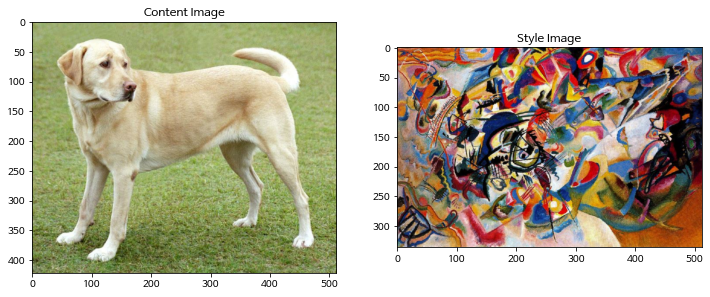

In [5]:
#  컨텐츠 이미지 1장과 스타일 이미지 1장 

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_img(content_path)

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# TF.HUB를 통한 스타일 전이 결과 확인

In [6]:
def apply_by_tfhub():
    
    x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
    x = tf.image.resize(x, (224,224))
    vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
    pred_probs = vgg(x)    
    
    pred_top5 = tf.keras.applications.vgg19.decode_predictions(pred_probs.numpy())[0]
    print(pred_top5)
    
apply_by_tfhub()    

[('n02099712', 'Labrador_retriever', 0.49317262), ('n02099601', 'golden_retriever', 0.23665187), ('n02104029', 'kuvasz', 0.036357313), ('n02099849', 'Chesapeake_Bay_retriever', 0.024182774), ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646035)]


# VGG19 에서 사용할 레이어 선정 및 모델 생성 

In [7]:
vgg19 = tf.keras.applications.VGG19(include_top=False)
for layer in vgg19.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [8]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def vgg_layer(layer_names):
    vgg19 = tf.keras.applications.VGG19(include_top=False)    
    vgg19.trainable = False
    
    outputs = [ vgg19.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg19.input], outputs)
    return model

style_extractor = vgg_layer(style_layers)

In [10]:
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  크기: ", output.numpy().shape)
    print("  최솟값: ", output.numpy().min())
    print("  최댓값: ", output.numpy().max())
    print("  평균: ", output.numpy().mean())
    print()

block1_conv1
  크기:  (1, 336, 512, 64)
  최솟값:  0.0
  최댓값:  835.5255
  평균:  33.97525

block2_conv1
  크기:  (1, 168, 256, 128)
  최솟값:  0.0
  최댓값:  4625.8867
  평균:  199.82687

block3_conv1
  크기:  (1, 84, 128, 256)
  최솟값:  0.0
  최댓값:  8789.24
  평균:  230.78099

block4_conv1
  크기:  (1, 42, 64, 512)
  최솟값:  0.0
  최댓값:  21566.133
  평균:  791.24005

block5_conv1
  크기:  (1, 21, 32, 512)
  최솟값:  0.0
  최댓값:  3189.2532
  평균:  59.179478



In [11]:
# 스타일 계산 
#  - 각 feature map간의 상관관계 
#    - 각 레이어별 그램 매트릭스 

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    denom = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / denom

# 스타일과 콘텐츠 추출하기 
class StyleContentModel(tf.keras.models.Model):
    
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        
        # pretrained 된 VGG19를 이용한 layer 출력 list
        self.vgg = vgg_layer(self.style_layers + self.content_layers)
        self.num_style_layers = len(self.style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # inputs 은 [0,1] 사이의 실수값
        
        inputs = inputs * 255.0
        
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        style_outputs, content_outputs = outputs[:self.num_style_layers], outputs[self.num_style_layers:]
        
        # gram matrix 값 확보 
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        # dict 화
        style_dict = {layer_name:output 
            for layer_name, output in zip(self.style_layers, style_outputs) }
        
        content_dict = {layer_name:output 
            for layer_name, output in zip(self.content_layers, content_outputs)}
        
        return {'style':style_dict, 'content':content_dict } 

In [12]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(content_image)

print('스타일:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
#     print("    최솟값: ", output.numpy().min())
#     print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())
    print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    크기: ", output.numpy().shape)
#     print("    최솟값: ", output.numpy().min())
#     print("    최댓값: ", output.numpy().max())
    print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    평균:  263.79025

   block2_conv1
    크기:  (1, 128, 128)
    평균:  9100.949

   block3_conv1
    크기:  (1, 256, 256)
    평균:  7660.9766

   block4_conv1
    크기:  (1, 512, 512)
    평균:  134288.86

   block5_conv1
    크기:  (1, 512, 512)
    평균:  1487.0381

콘텐츠:
   block5_conv2
    크기:  (1, 26, 32, 512)
    평균:  13.764152


# 학습 타켓 결정

In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
style_targets.keys()

dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])

# 생성하고자 하는 이미지 Variable 정의

In [44]:
image = tf.Variable(content_image)

# 경사하강법으로 학습 

In [17]:
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # tf.add_n : element-wise add
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[layer_name] - style_targets[layer_name])**2) for layer_name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[layer_name] - content_targets[layer_name])**2) for layer_name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers    
    
    loss = style_loss + content_loss
    
    return loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # image의 개조 by grad        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    
    # image clip [0,1]    
    image.assign(clip_0_1(image))    

    

## 시험삼아 몇 step 으로 이미지 개선 진행

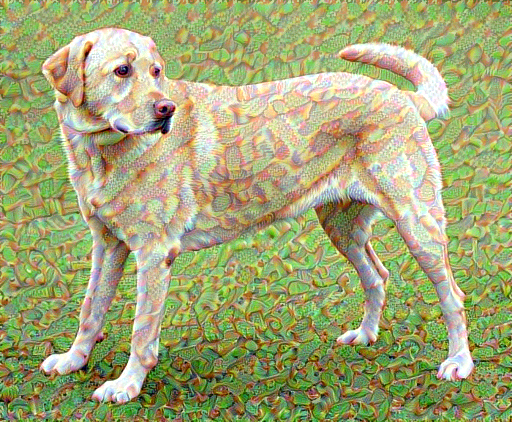

In [62]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

## 잘 작동하므로 오랫동안 최적화 

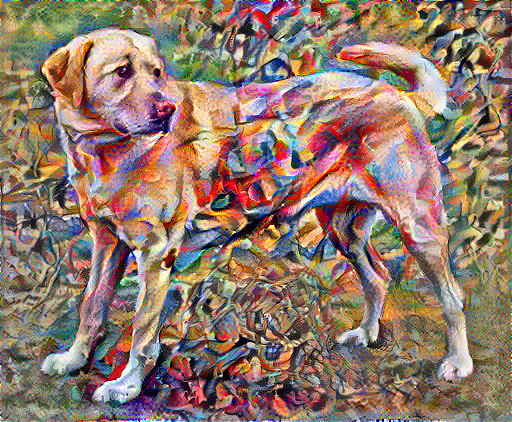

훈련 스텝: 1000
전체 소요 시간: 872.6


In [65]:
import time
start = time.time()

epochs = 10
step_per_epochs = 100
step = 0

for n in range(epochs):
    for m in range(step_per_epochs):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("훈련 스텝: {}".format(step))    

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))

# 총 변위 손실(total variation loss) 정의 및 시각화

* 이미지 상에 포함된 고주파 성분(edge detected like)이 많음을 확인 
* 원본 이미지의 고주파(x_delta, y_delta)와 생성 이미지의 고주파 성분을 비교해보면 늘어난 것을 확인

In [19]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

    return x_var, y_var

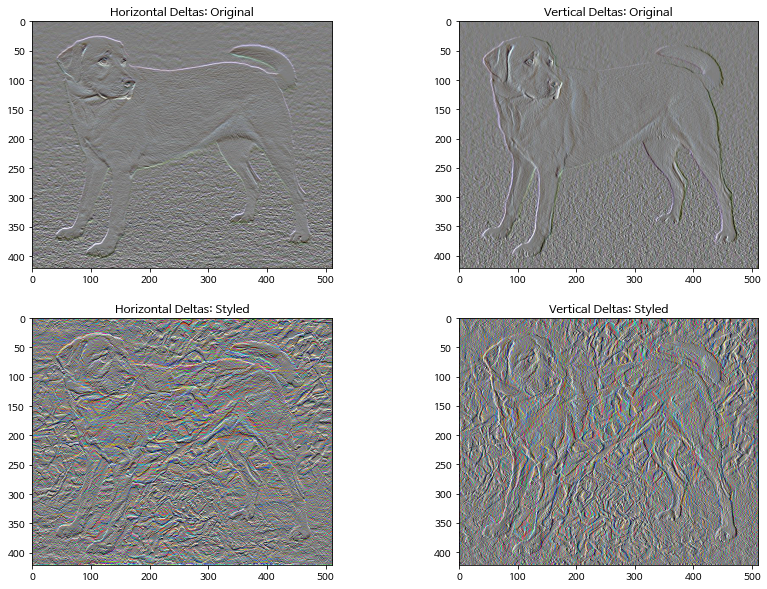

In [66]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")



#  총 변위 손실을 loss에 추가시켜서 이미지 개선시 고주파 억제

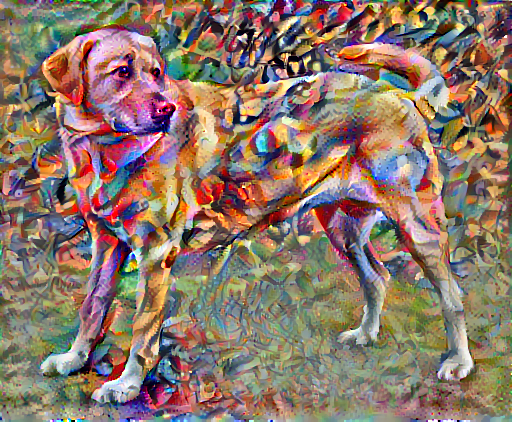

훈련 스텝: 1000
전체 소요 시간: 879.2


In [67]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_weight = 30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * total_variation_loss(image)

    # image의 개조 by grad        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    
    # image clip [0,1]    
    image.assign(clip_0_1(image))    

image = tf.Variable(content_image)
    
import time
start = time.time()

epochs = 10
step_per_epochs = 100
step = 0

for n in range(epochs):
    for m in range(step_per_epochs):
        step += 1
        train_step(image)
        print('.', end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("훈련 스텝: {}".format(step))    

end = time.time()
print("전체 소요 시간: {:.1f}".format(end-start))    

## 다시 한번 변위 출력

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")
